# Stock Data Collection and Basic Cleaning

## Objective
This notebook fetches historical stock data for 20 selected companies and performs basic cleaning operations. The cleaned datasets will be saved to `data/cleaned/` for further processing by model-specific preparation notebooks.

## Purpose
The goal is to create a clean dataset with appropriate features and multiple target variables for different prediction horizons:
- Next day closing price
- Next week average price
- Next month average price

Each of these targets will be used to train separate specialized models, allowing for higher accuracy across different prediction timeframes.

## Steps:
1. Import necessary libraries
2. Define companies list
3. Fetch historical data using yfinance
4. Perform basic cleaning
5. Add prediction targets for multiple timeframes
6. Visualize the data
7. Save cleaned datasets
8. Perform data quality checks

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Define Stock List

We'll use a predefined list of 20 companies representing different sectors for our analysis. This provides a diverse dataset for model training.

In [2]:
# Define list of companies with symbols
stocks = [
    "AAPL", "MSFT", "GOOG", "AMZN", "TSLA", 
    "FB", "NVDA", "SPY", "V", "DIS", 
    "NFLX", "PYPL", "BABA", "IBM", "AMD", 
    "BA", "INTC", "T", "GS", "NKE"
]

# Note: FB is now META, but we'll try both to ensure we get data
if "FB" in stocks:
    stocks.append("META")
    
print(f"Total stocks to analyze: {len(stocks)}")

Total stocks to analyze: 21


## 2. Create Output Directory

Define and create the directory where cleaned data will be stored.

In [3]:
# Create output directory if it doesn't exist
output_dir = '../data/cleaned/'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {os.path.abspath(output_dir)}")

Output directory: /home/abderrahmane/Stock-Market-Predictor/ml/data/cleaned


## 3. Define Data Fetching Function

This function fetches historical data for a given stock ticker using the yfinance library. We'll retrieve 10 years of data to ensure we have sufficient history for training our models.

In [4]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data for a given ticker symbol.
    
    Parameters:
    - ticker: Stock symbol
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame with historical stock data
    """
    
    try:
        # Fetch data using yfinance
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)
        
        # Check if we got any data
        if df.empty:
            print(f"No data found for {ticker}")
            return None
        
        # Add ticker column
        df['Symbol'] = ticker
        
        # Get company info for additional metadata
        try:
            info = stock.info
            df['Sector'] = info.get('sector', 'Unknown')
            df['Industry'] = info.get('industry', 'Unknown')
        except:
            print(f"Could not retrieve company info for {ticker}")
            df['Sector'] = 'Unknown'
            df['Industry'] = 'Unknown'
        
        print(f"Successfully fetched data for {ticker}: {len(df)} rows")
        return df
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

## 4. Define Data Cleaning Function

This function performs essential cleaning operations and feature engineering on the raw stock data. Key components include:

1. Basic cleaning (standardizing column names, handling missing values)
2. Feature engineering (moving averages, volatility, returns)
3. Creating prediction targets for three different time horizons:
   - Next day closing price
   - Next week average price (5 trading days)
   - Next month average price (21 trading days)

In [5]:
def clean_stock_data(df):
    """
    Perform basic cleaning operations on stock data and create prediction targets.
    
    Parameters:
    - df: DataFrame with stock data
    
    Returns:
    - Cleaned DataFrame with prediction targets
    """
    if df is None or df.empty:
        return None
    
    # Make a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Reset index to make Date a column
    df_clean = df_clean.reset_index()
    
    # Ensure Date column is datetime
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])
    
    # Rename columns to standard format
    df_clean = df_clean.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume',
        'Dividends': 'dividends',
        'Stock Splits': 'splits',
        'Symbol': 'symbol',
        'Date': 'date'
    })
    
    # Handle missing values
    df_clean[['open', 'high', 'low', 'close']] = df_clean[['open', 'high', 'low', 'close']].fillna(method='ffill')
    df_clean['volume'] = df_clean['volume'].fillna(0)
    df_clean['dividends'] = df_clean['dividends'].fillna(0)
    df_clean['splits'] = df_clean['splits'].fillna(0)
    
    # Add derived features
    df_clean['return'] = df_clean['close'].pct_change()  # Daily returns
    
    # Moving averages
    df_clean['ma5'] = df_clean['close'].rolling(window=5).mean()
    df_clean['ma20'] = df_clean['close'].rolling(window=20).mean()
    df_clean['ma50'] = df_clean['close'].rolling(window=50).mean()
    
    # Volatility and volume features
    df_clean['volatility'] = df_clean['return'].rolling(window=20).std()
    df_clean['volume_ma20'] = df_clean['volume'].rolling(window=20).mean()
    
    # Date features
    df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['year'] = df_clean['date'].dt.year
    
    # Handle NaN values created by rolling calculations
    df_clean = df_clean.fillna(method='bfill')
    df_clean = df_clean.dropna()
    
    # Drop rows with extreme values (potential data errors)
    df_clean = df_clean[(df_clean['return'] > -0.5) & (df_clean['return'] < 0.5)]
    
    # Create prediction targets for multiple timeframes
    # 1. Next day closing price
    df_clean['next_day_close'] = df_clean['close'].shift(-1)
    
    # 2. Next week average price (5 trading days)
    # Calculate forward-looking rolling average
    shifted_close = pd.Series(df_clean['close'].values)
    # For each row, calculate average of next 5 days
    next_week_avgs = []
    for i in range(len(shifted_close)):
        if i + 5 < len(shifted_close):
            next_week_avgs.append(shifted_close[i+1:i+6].mean())
        else:
            next_week_avgs.append(np.nan)
    df_clean['next_week_avg'] = next_week_avgs
    
    # 3. Next month average price (21 trading days)
    next_month_avgs = []
    for i in range(len(shifted_close)):
        if i + 21 < len(shifted_close):
            next_month_avgs.append(shifted_close[i+1:i+22].mean())
        else:
            next_month_avgs.append(np.nan)
    df_clean['next_month_avg'] = next_month_avgs
    
    # Drop rows with NaN prediction targets (last 21 days of data)
    df_clean = df_clean.dropna()
    
    return df_clean

## 5. Define Visualization Function

This function creates visualizations to help understand the data and verify the cleaning process was successful.

In [6]:
def visualize_stock_data(df, ticker):
    """
    Create visualizations for the stock data.
    
    Parameters:
    - df: DataFrame with stock data
    - ticker: Stock symbol
    """
    if df is None or df.empty:
        print(f"No data to visualize for {ticker}")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(14, 20))
    
    # Plot 1: Price history with moving averages
    axes[0].plot(df['date'], df['close'], label='Close Price')
    axes[0].plot(df['date'], df['ma20'], label='20-day MA', alpha=0.7)
    axes[0].plot(df['date'], df['ma50'], label='50-day MA', alpha=0.7)
    axes[0].set_title(f'{ticker} - Price History')
    axes[0].set_ylabel('Price ($)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: Volume
    axes[1].bar(df['date'], df['volume'], alpha=0.7, color='blue')
    axes[1].plot(df['date'], df['volume_ma20'], color='red', alpha=0.7, label='20-day Volume MA')
    axes[1].set_title(f'{ticker} - Trading Volume')
    axes[1].set_ylabel('Volume')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot 3: Returns and Volatility
    ax3 = axes[2]
    ax3.plot(df['date'], df['return'], label='Daily Returns', alpha=0.5, color='green')
    ax3.set_ylabel('Returns', color='green')
    ax3.tick_params(axis='y', labelcolor='green')
    ax3.set_title(f'{ticker} - Returns and Volatility')
    
    ax3b = ax3.twinx()
    ax3b.plot(df['date'], df['volatility'], label='Volatility (20-day)', color='red', alpha=0.7)
    ax3b.set_ylabel('Volatility', color='red')
    ax3b.tick_params(axis='y', labelcolor='red')
    
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3b.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax3.grid(True)
    
    # Plot 4: Prediction Targets
    # Select just the last year of data for clarity
    last_year = df[df['date'] > df['date'].max() - pd.Timedelta(days=365)]
    
    axes[3].plot(last_year['date'], last_year['close'], label='Actual Close', color='blue')
    axes[3].plot(last_year['date'], last_year['next_day_close'], label='Next Day Close', color='green', linestyle='--')
    axes[3].plot(last_year['date'], last_year['next_week_avg'], label='Next Week Avg', color='orange', linestyle=':')
    axes[3].plot(last_year['date'], last_year['next_month_avg'], label='Next Month Avg', color='red', linestyle='-.')
    axes[3].set_title(f'{ticker} - Prediction Targets (Last Year)')
    axes[3].set_ylabel('Price ($)')
    axes[3].legend()
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Monthly Returns & Target Prediction Horizons Comparison
    monthly_returns = df.groupby('month')['return'].mean()
    plt.figure(figsize=(12, 10))
    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Monthly returns plot
    ax1.bar(range(1, 13), monthly_returns, color=['green' if x > 0 else 'red' for x in monthly_returns])
    ax1.set_title(f'{ticker} - Average Monthly Returns')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Return')
    ax1.set_xticks(range(1, 13))
    ax1.grid(True, alpha=0.3)
    
    # Prediction horizons comparison (using last 90 days for clarity)
    last_90_days = df.iloc[-90:]
    ax2.plot(last_90_days['date'], last_90_days['close'], label='Actual Price', linewidth=2)
    ax2.plot(last_90_days['date'], last_90_days['next_day_close'], label='Next Day', linestyle='--')
    ax2.plot(last_90_days['date'], last_90_days['next_week_avg'], label='Next Week Avg', linestyle='-.')
    ax2.plot(last_90_days['date'], last_90_days['next_month_avg'], label='Next Month Avg', linestyle=':')
    ax2.set_title(f'{ticker} - Prediction Targets (Last 90 Days)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Fetch and Clean Data for All Stocks

Now we'll fetch and clean data for all stocks in our list, creating standardized datasets ready for model-specific preparation.

In [10]:
# Define date range (10 years of data)
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)  # 10 years

print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Process each stock
results = {}

for ticker in stocks:
    print(f"Processing {ticker}...")
    
    # Fetch data
    df = fetch_stock_data(ticker, start_date, end_date)
    
    if df is not None and not df.empty:
        # Clean data
        cleaned_df = clean_stock_data(df)
        
        if cleaned_df is not None and not cleaned_df.empty:
            results[ticker] = cleaned_df
            print(f"Cleaned data shape for {ticker}: {cleaned_df.shape}")
            
            # Save cleaned data
            output_file = os.path.join(output_dir, f"{ticker}.csv")
            cleaned_df.to_csv(output_file, index=False)
            print(f"Saved cleaned data to {output_file}")
        else:
            print(f"No clean data available for {ticker} after processing")
    else:
        print(f"Skipping {ticker} due to data fetch issues")

print(f"Successfully processed {len(results)} out of {len(stocks)} stocks")

Fetching data from 2015-05-14 to 2025-05-11
Processing AAPL...
Successfully fetched data for AAPL: 2513 rows
Cleaned data shape for AAPL: (2492, 23)
Saved cleaned data to ../data/cleaned/AAPL.csv
Processing MSFT...
Successfully fetched data for MSFT: 2513 rows
Cleaned data shape for MSFT: (2492, 23)
Saved cleaned data to ../data/cleaned/MSFT.csv
Processing GOOG...
Successfully fetched data for GOOG: 2513 rows
Cleaned data shape for GOOG: (2492, 23)
Saved cleaned data to ../data/cleaned/GOOG.csv
Processing AMZN...
Successfully fetched data for AMZN: 2513 rows
Cleaned data shape for AMZN: (2492, 23)
Saved cleaned data to ../data/cleaned/AMZN.csv
Processing TSLA...
Successfully fetched data for TSLA: 2513 rows
Cleaned data shape for TSLA: (2492, 23)
Saved cleaned data to ../data/cleaned/TSLA.csv
Processing FB...


$FB: possibly delisted; no timezone found


No data found for FB
Skipping FB due to data fetch issues
Processing NVDA...
Successfully fetched data for NVDA: 2513 rows
Cleaned data shape for NVDA: (2492, 23)
Saved cleaned data to ../data/cleaned/NVDA.csv
Processing SPY...
Successfully fetched data for SPY: 2513 rows
Cleaned data shape for SPY: (2492, 24)
Saved cleaned data to ../data/cleaned/SPY.csv
Processing V...
Successfully fetched data for V: 2513 rows
Cleaned data shape for V: (2492, 23)
Saved cleaned data to ../data/cleaned/V.csv
Processing DIS...
Successfully fetched data for DIS: 2513 rows
Cleaned data shape for DIS: (2492, 23)
Saved cleaned data to ../data/cleaned/DIS.csv
Processing NFLX...
Successfully fetched data for NFLX: 2513 rows
Cleaned data shape for NFLX: (2492, 23)
Saved cleaned data to ../data/cleaned/NFLX.csv
Processing PYPL...
Successfully fetched data for PYPL: 2478 rows
Cleaned data shape for PYPL: (2457, 23)
Saved cleaned data to ../data/cleaned/PYPL.csv
Processing BABA...
Successfully fetched data for B

## 7. Visualize Sample Stock Data

Let's visualize a few stocks to understand their patterns and verify our data processing was successful.

Exception ignored in: <function tqdm.__del__ at 0x7f6b80a3c180>
Traceback (most recent call last):
  File "/home/abderrahmane/Stock-Market-Predictor/venv/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/abderrahmane/Stock-Market-Predictor/venv/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f6b80a3c180>
Traceback (most recent call last):
  File "/home/abderrahmane/Stock-Market-Predictor/venv/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/abderrahmane/Stock-Market-Predictor/venv/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'



Visualizing AAPL...


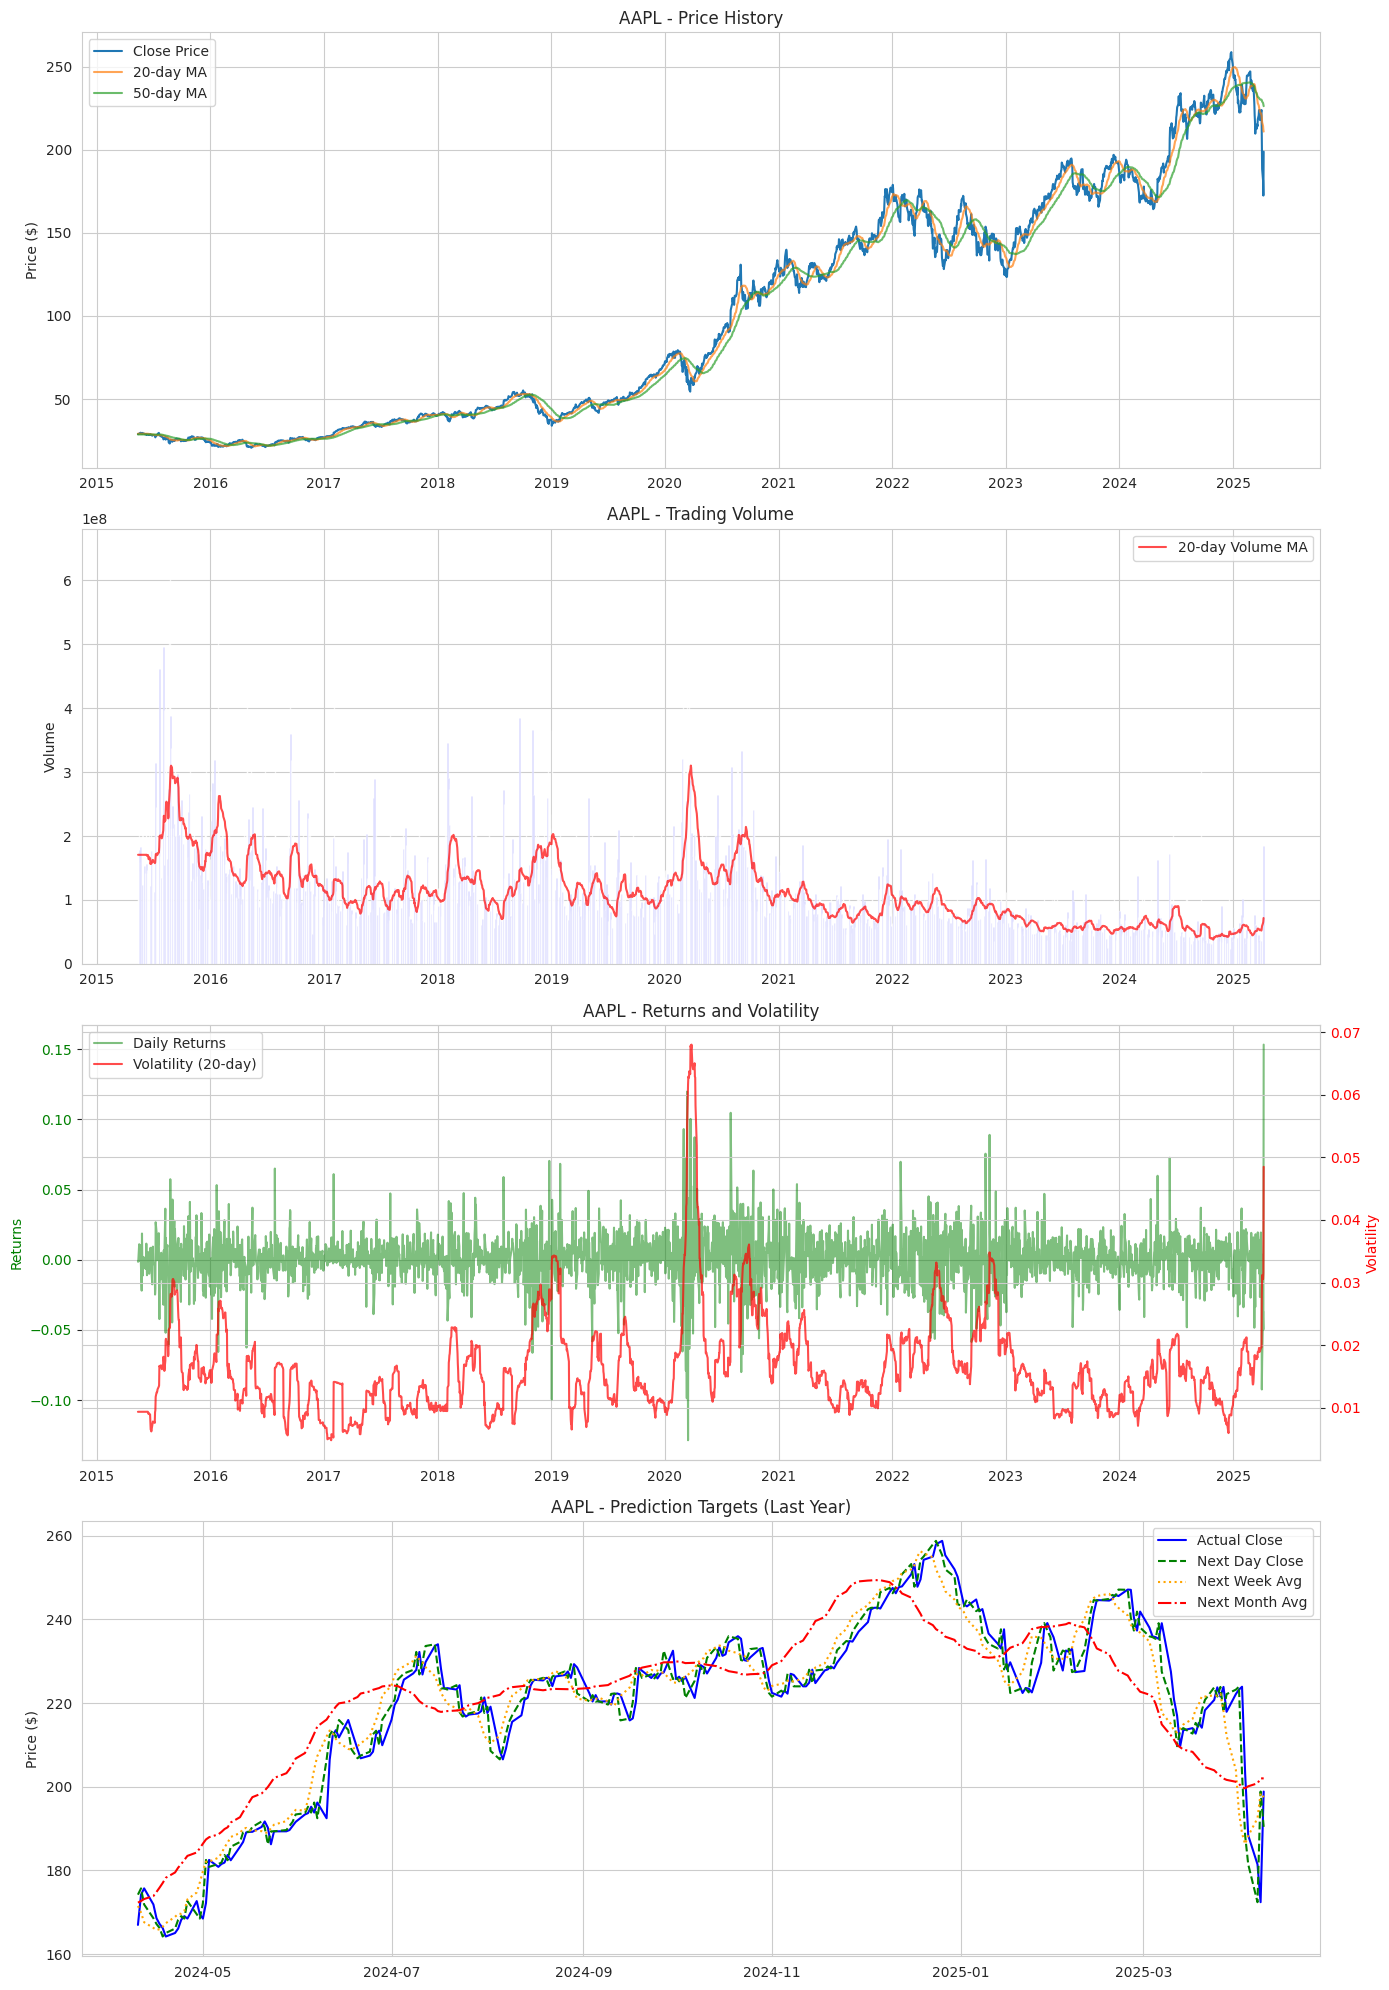

<Figure size 1200x1000 with 0 Axes>

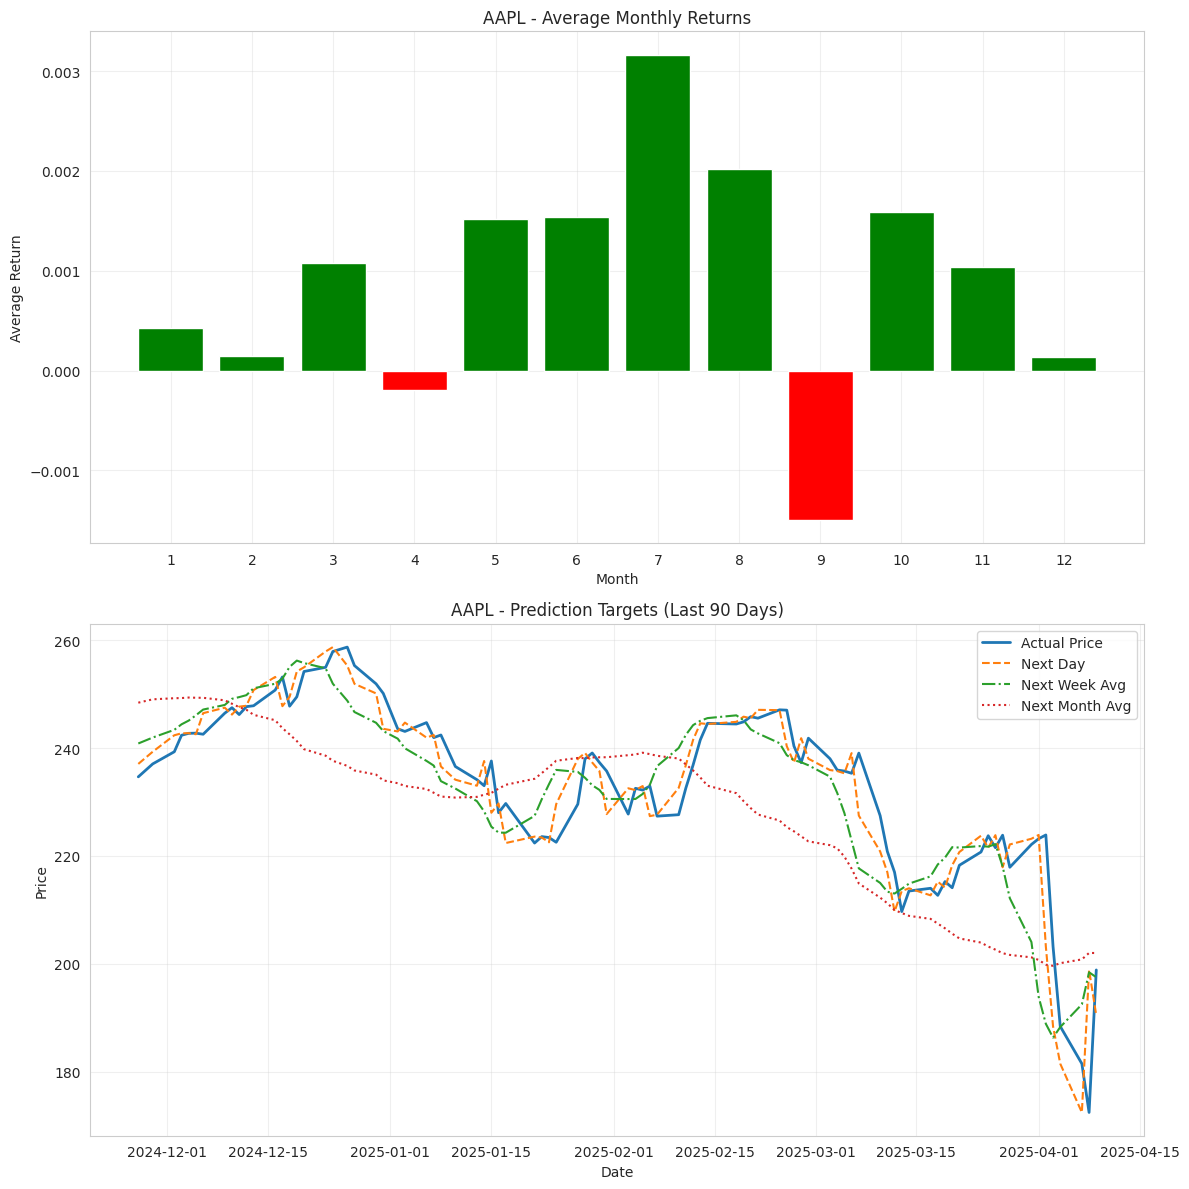


AAPL Statistics:
Data range: 2015-05-14 00:00:00-04:00 to 2025-04-09 00:00:00-04:00
Total trading days: 2492
Average daily return: 0.0009
Standard deviation of returns: 0.0184


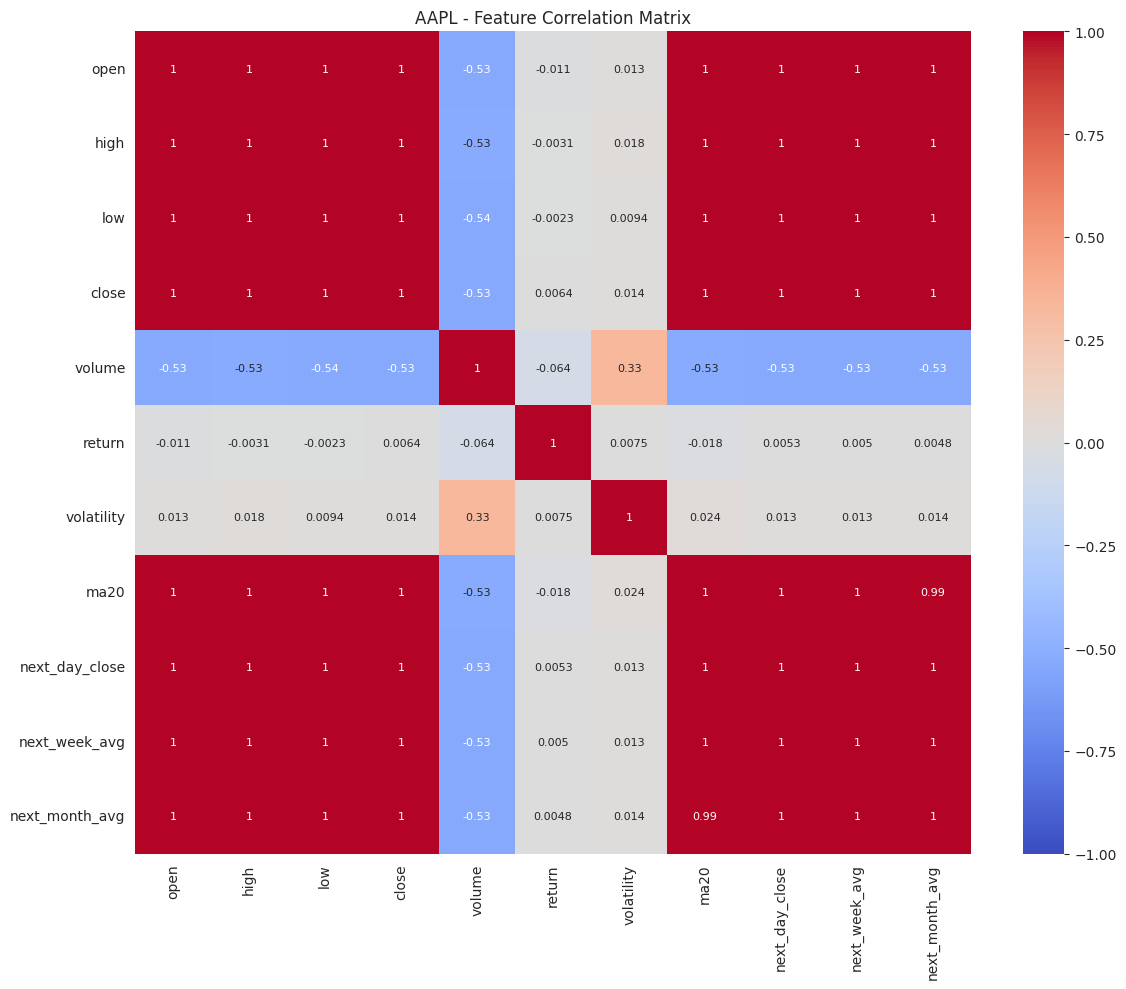


Visualizing MSFT...


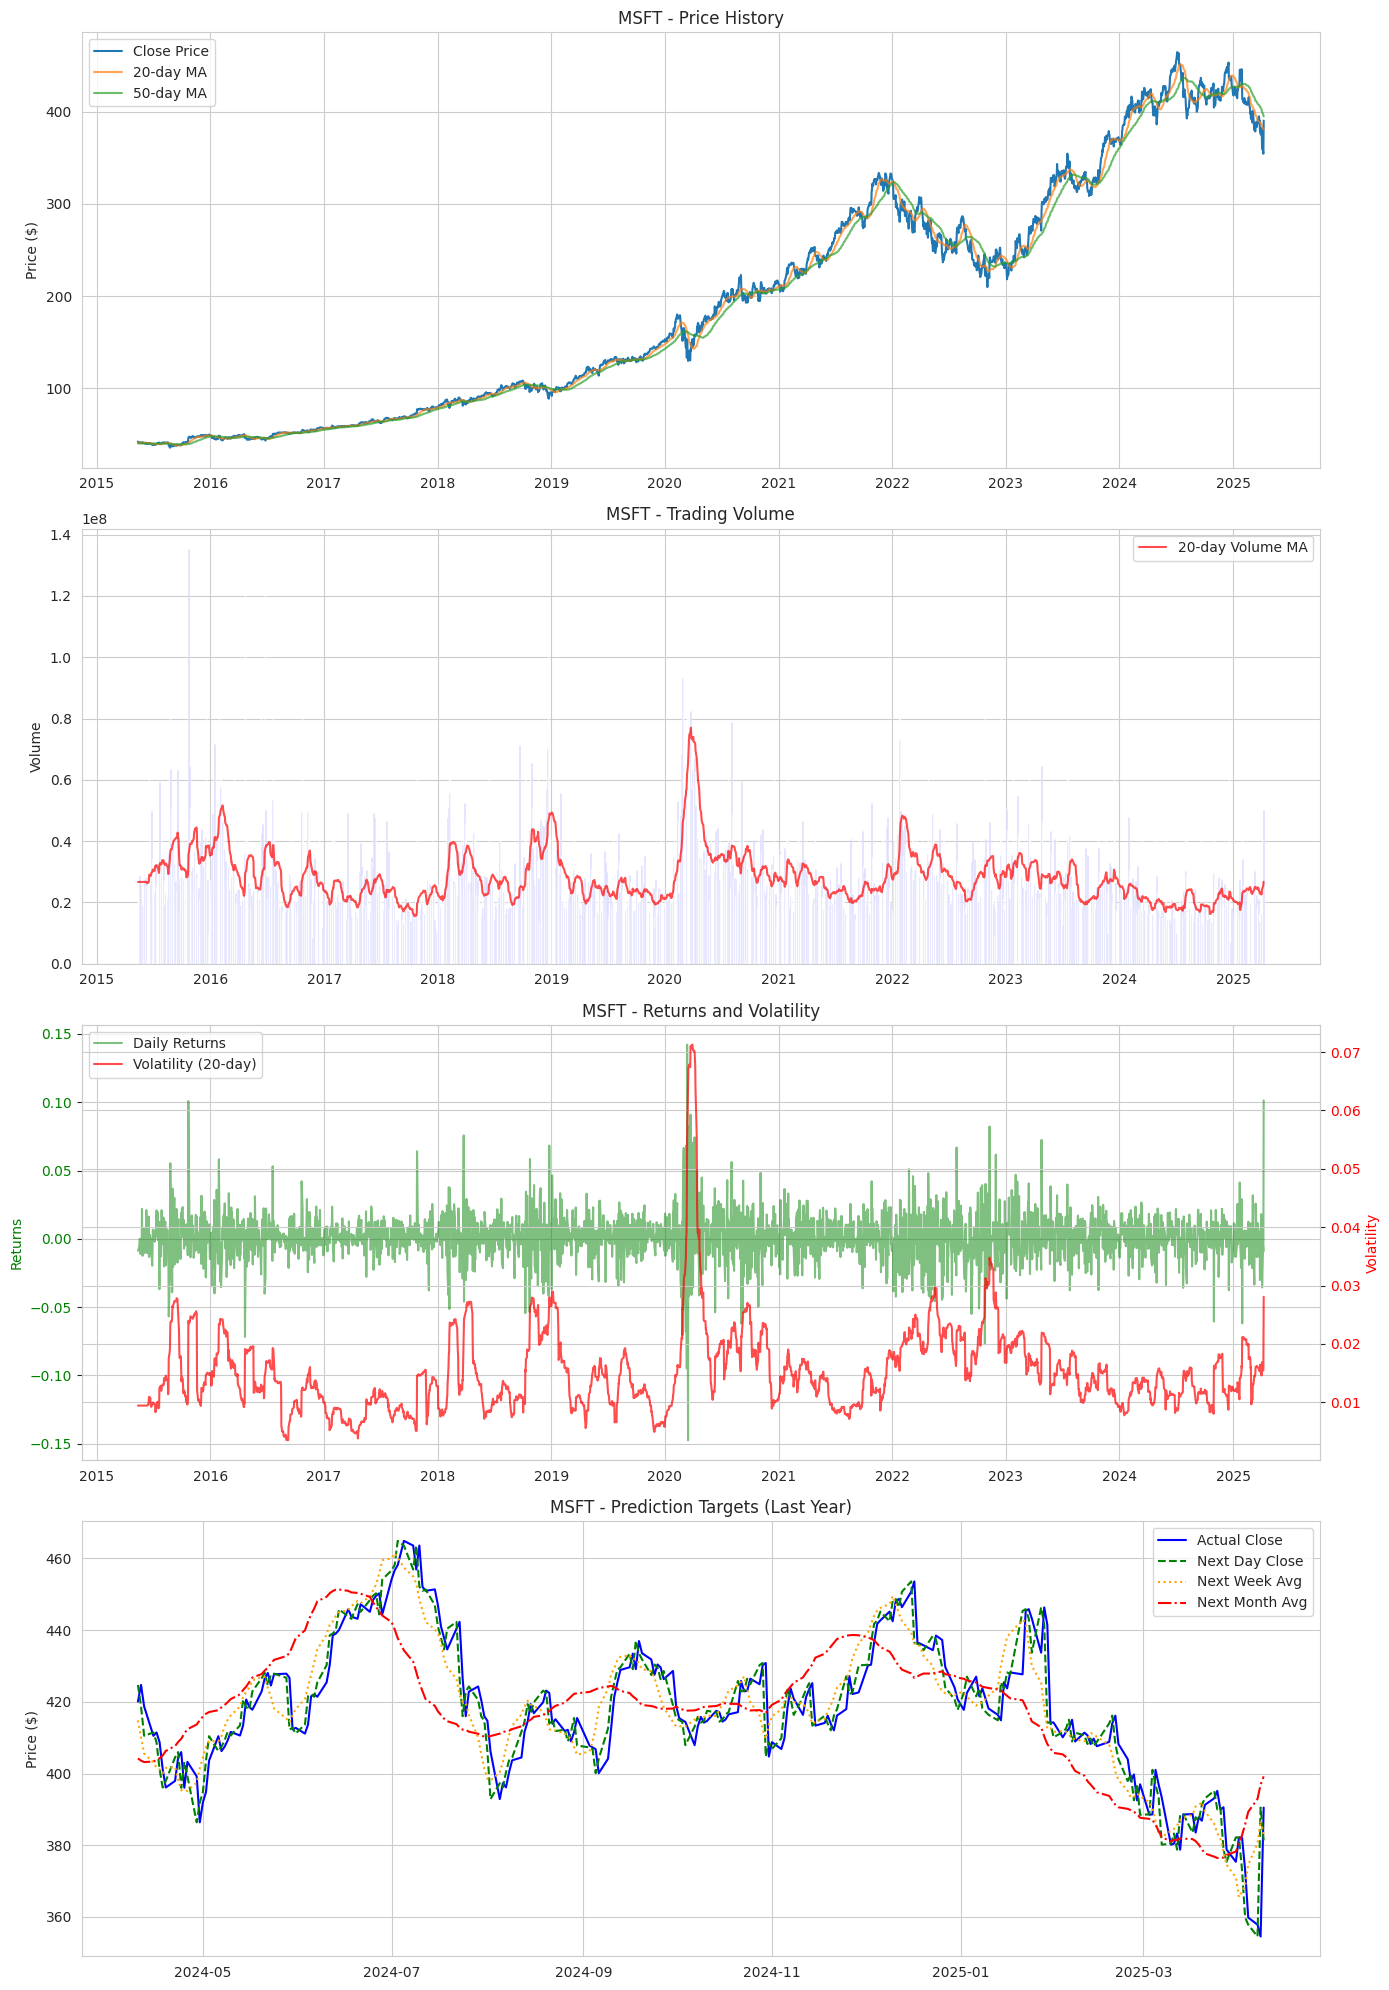

<Figure size 1200x1000 with 0 Axes>

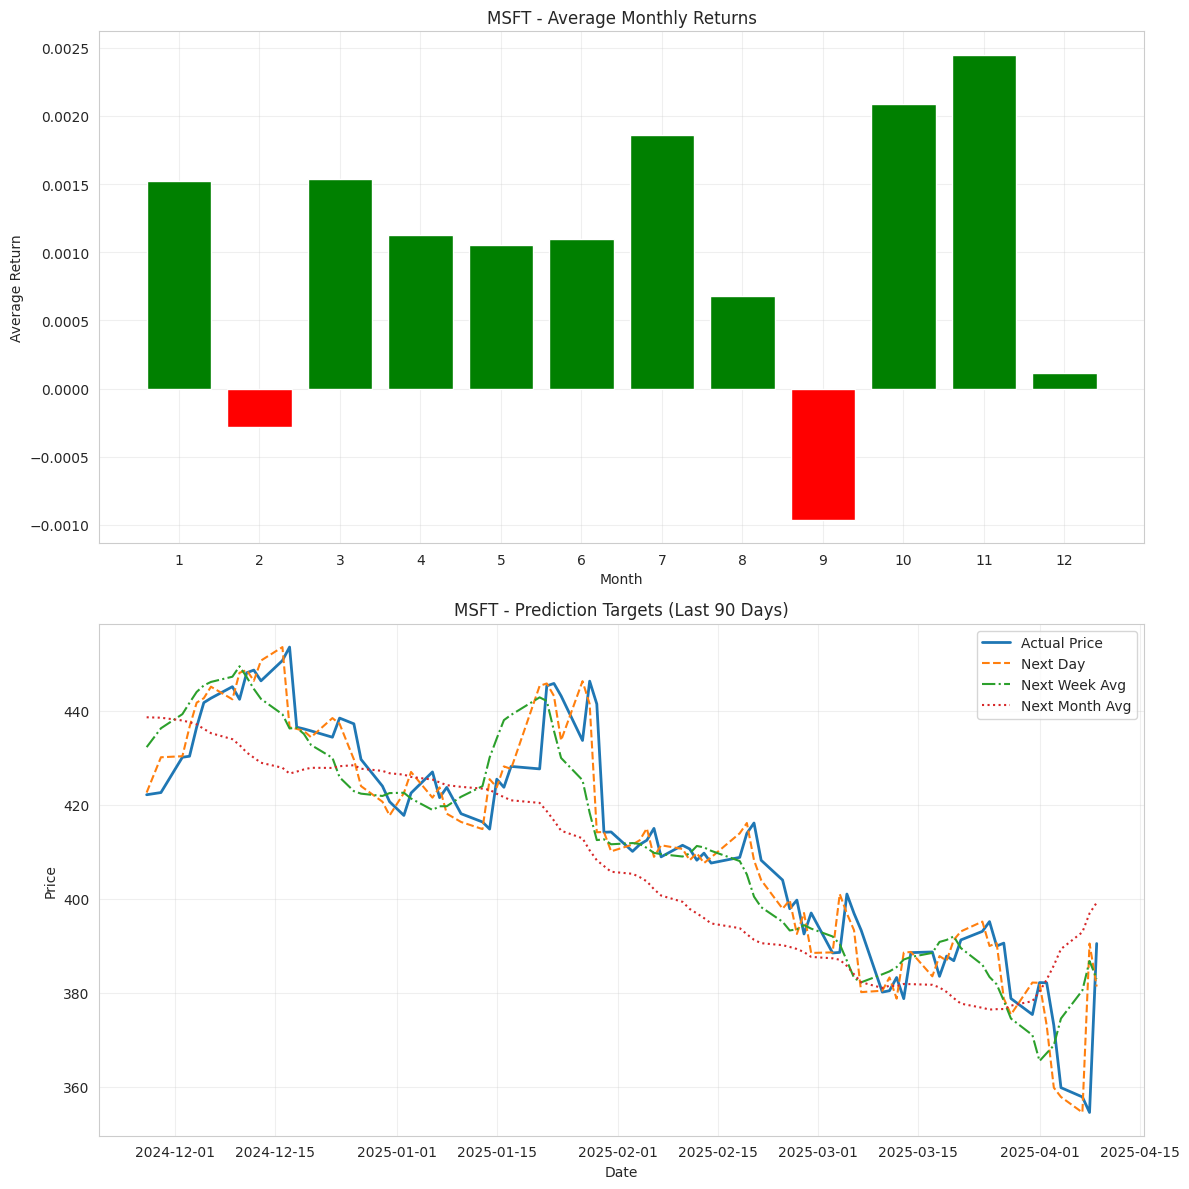


MSFT Statistics:
Data range: 2015-05-14 00:00:00-04:00 to 2025-04-09 00:00:00-04:00
Total trading days: 2492
Average daily return: 0.0010
Standard deviation of returns: 0.0171


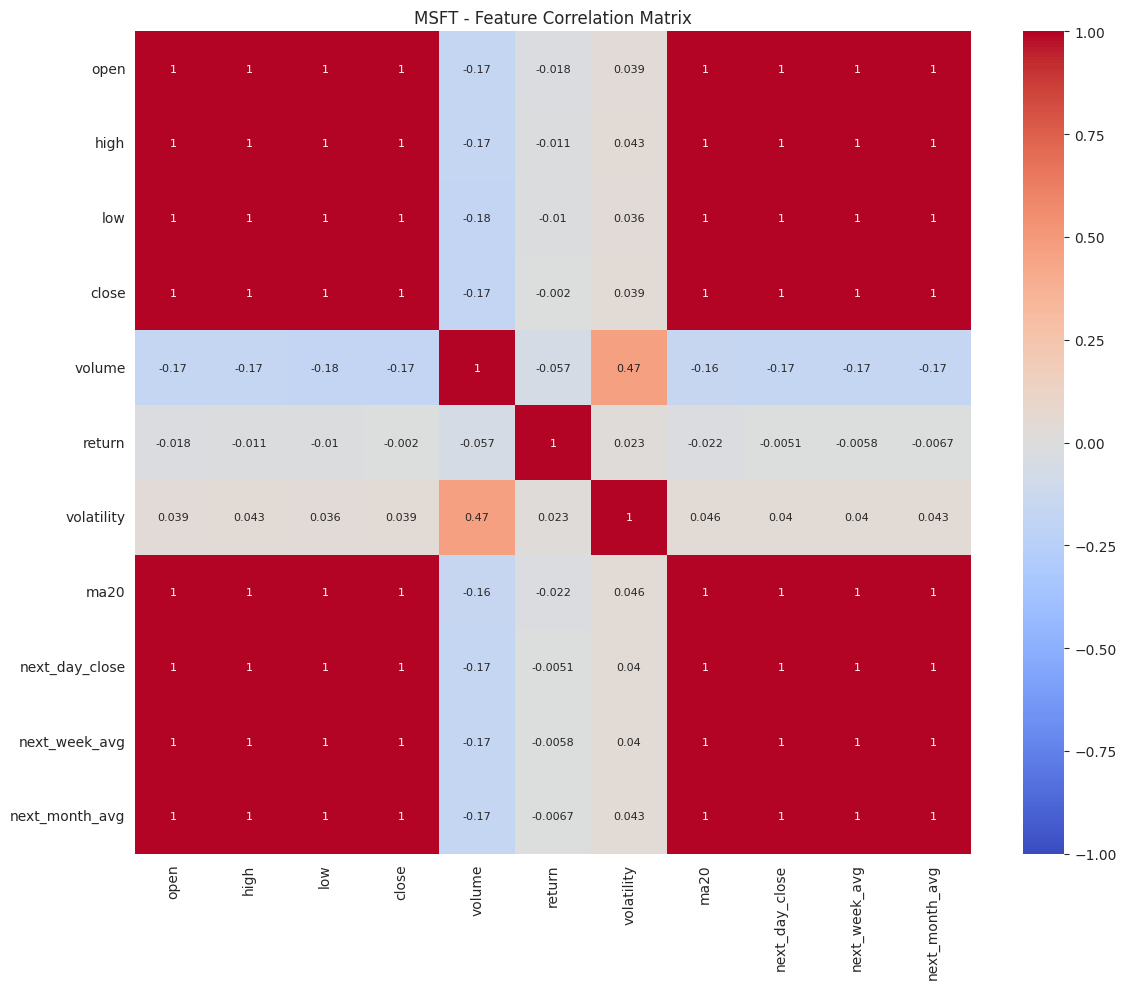


Visualizing TSLA...


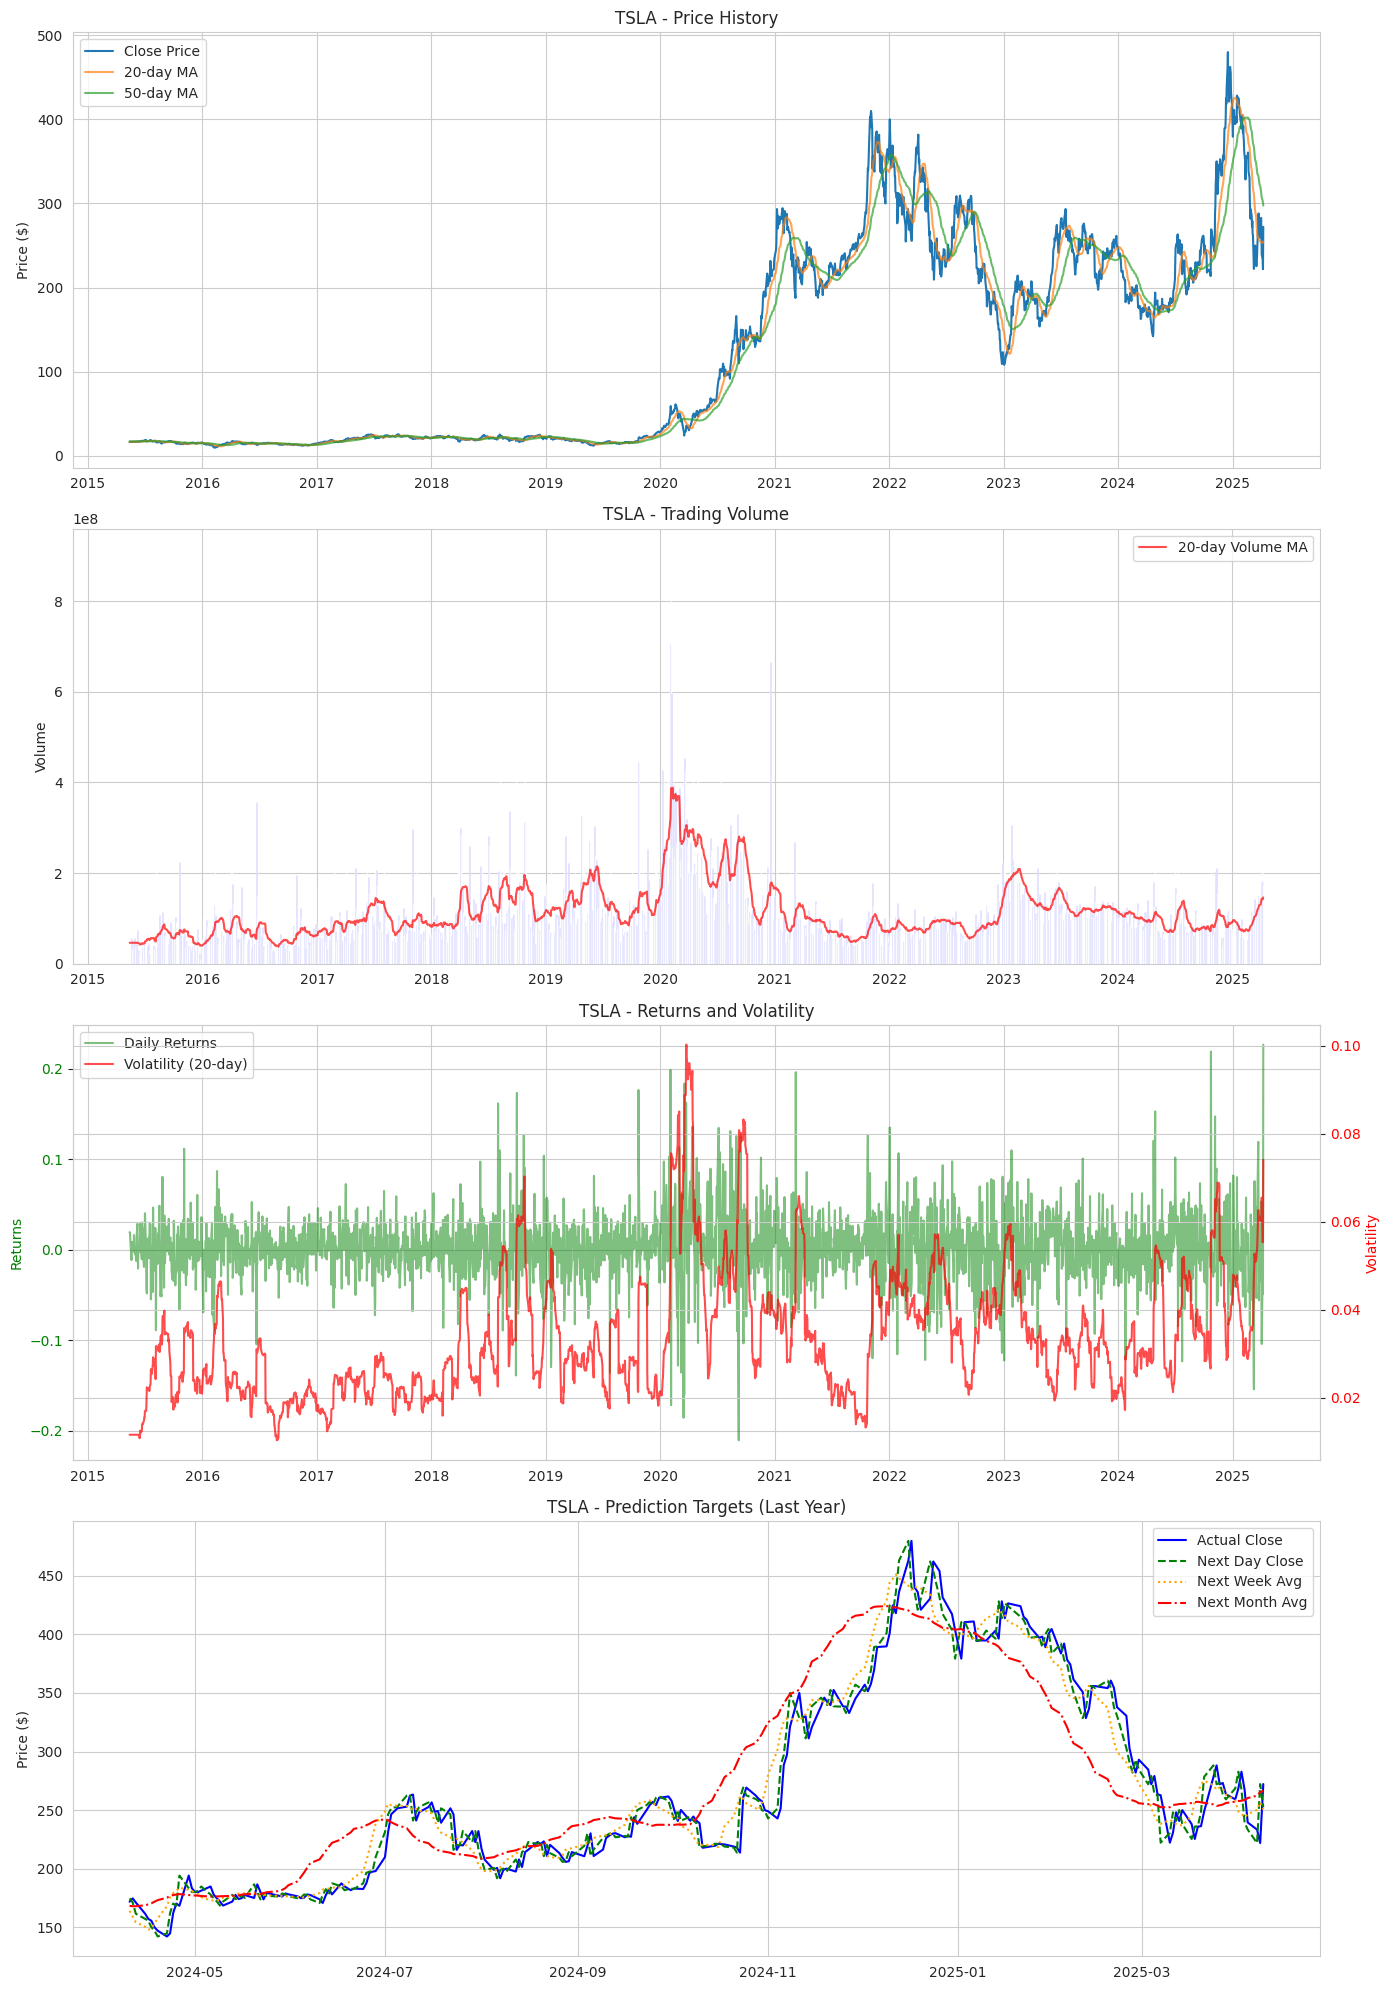

<Figure size 1200x1000 with 0 Axes>

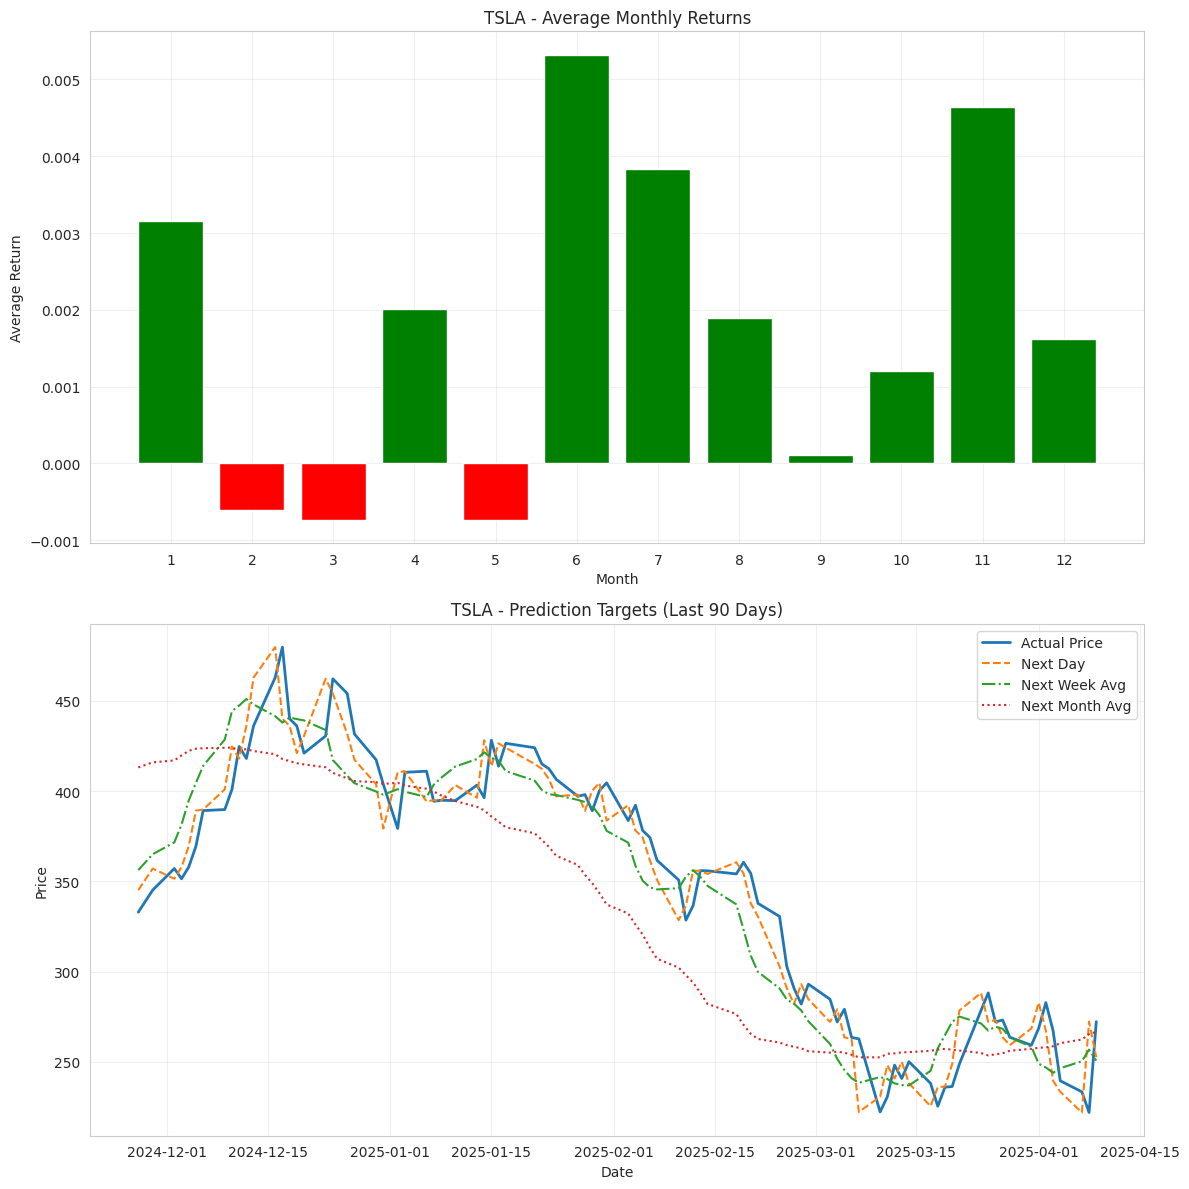


TSLA Statistics:
Data range: 2015-05-14 00:00:00-04:00 to 2025-04-09 00:00:00-04:00
Total trading days: 2492
Average daily return: 0.0018
Standard deviation of returns: 0.0370


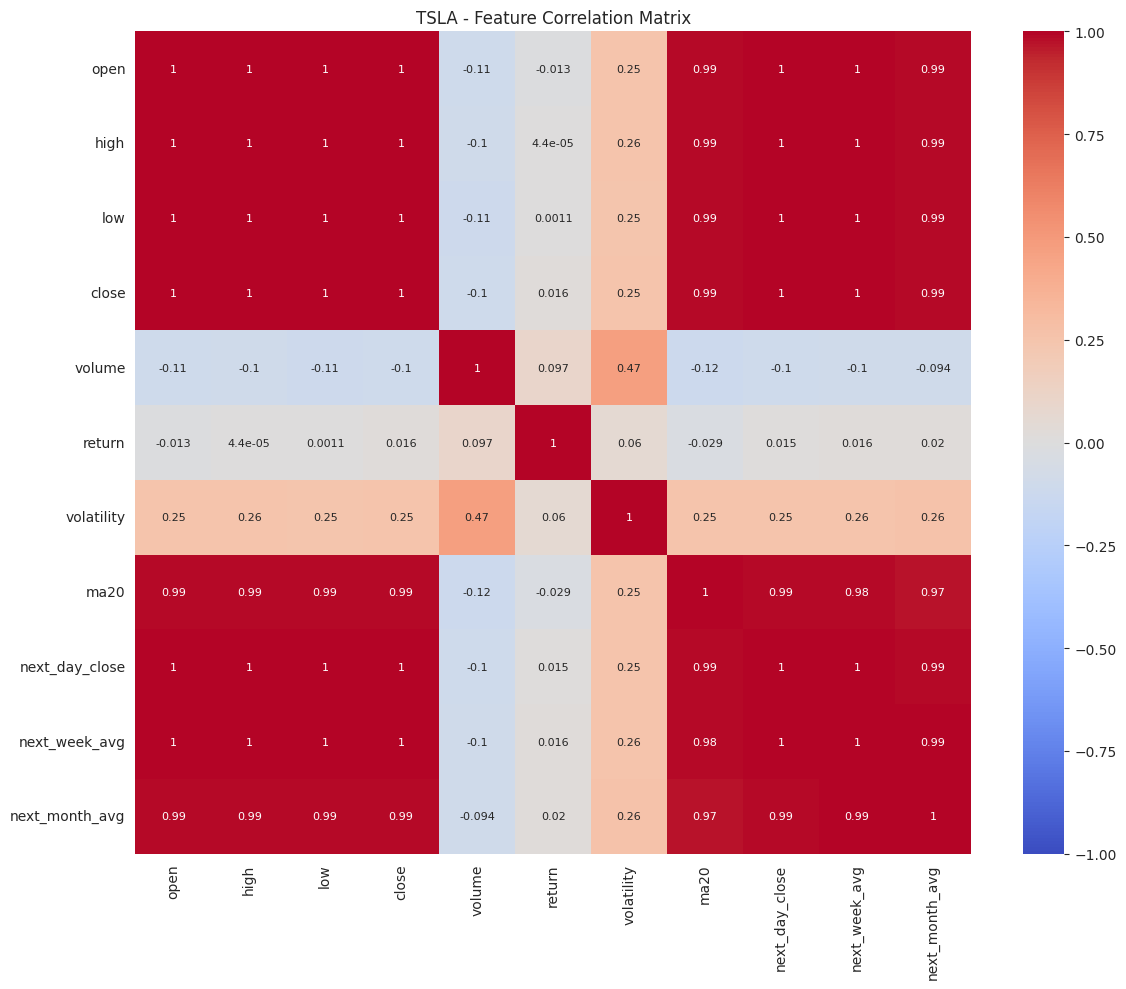


Visualizing NVDA...


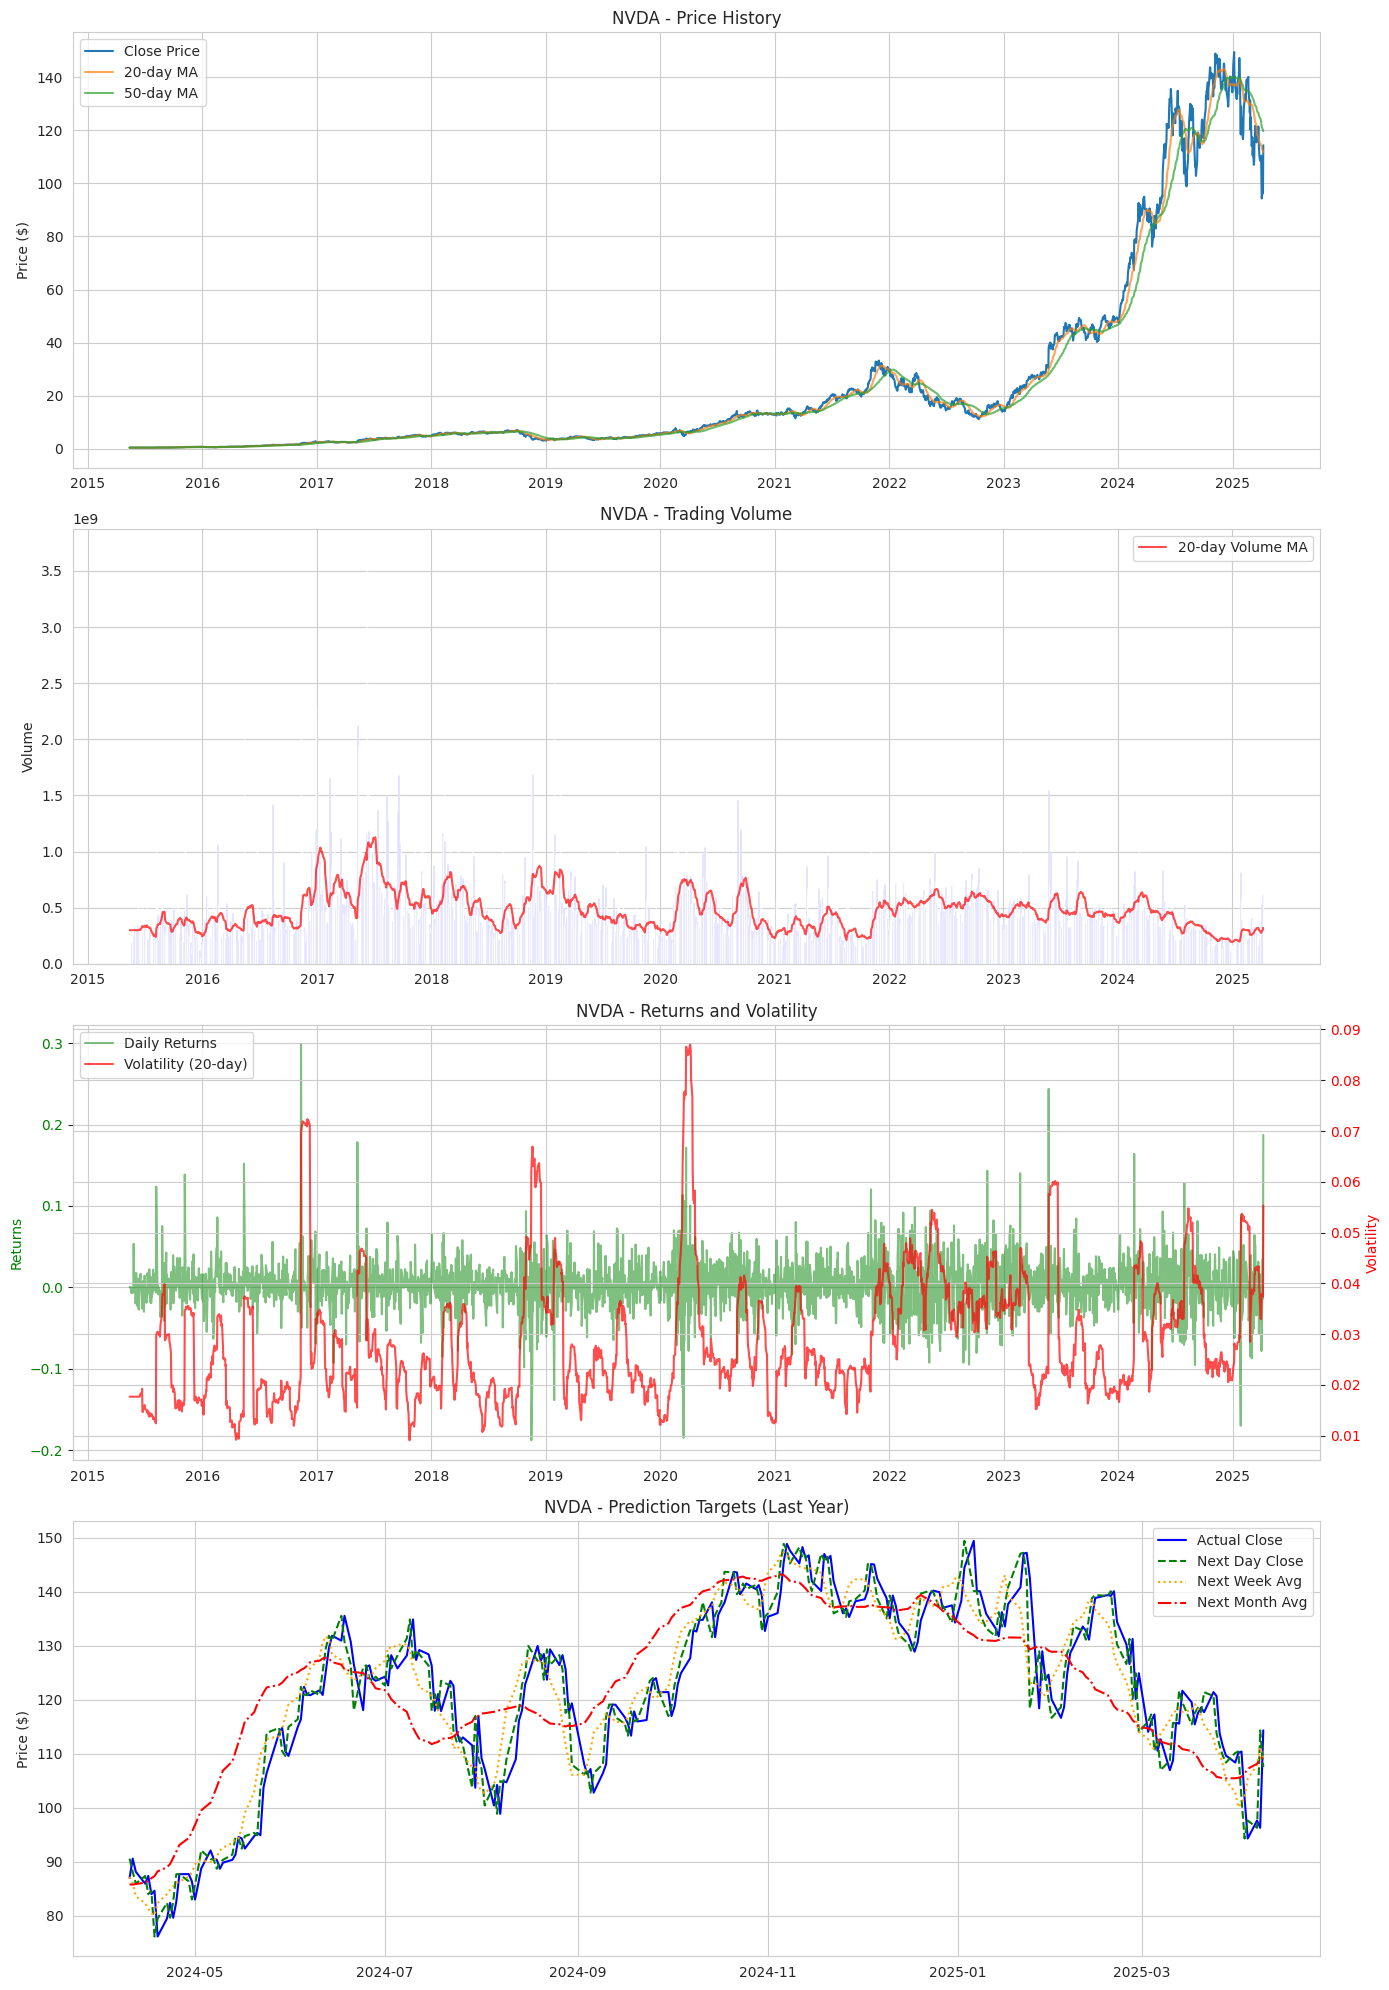

<Figure size 1200x1000 with 0 Axes>

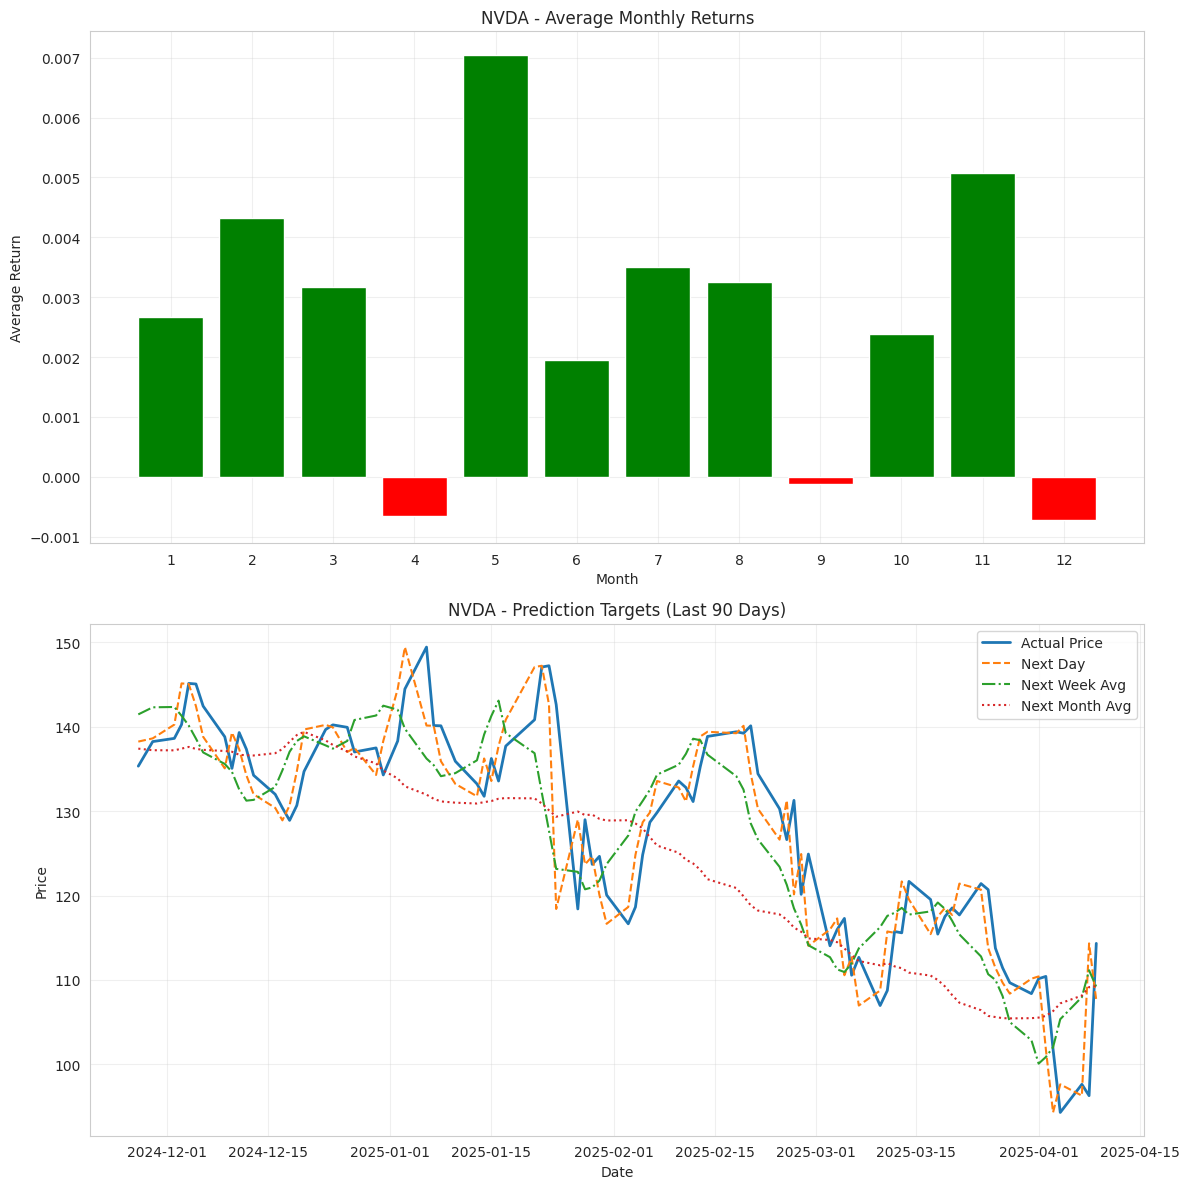


NVDA Statistics:
Data range: 2015-05-14 00:00:00-04:00 to 2025-04-09 00:00:00-04:00
Total trading days: 2492
Average daily return: 0.0027
Standard deviation of returns: 0.0315


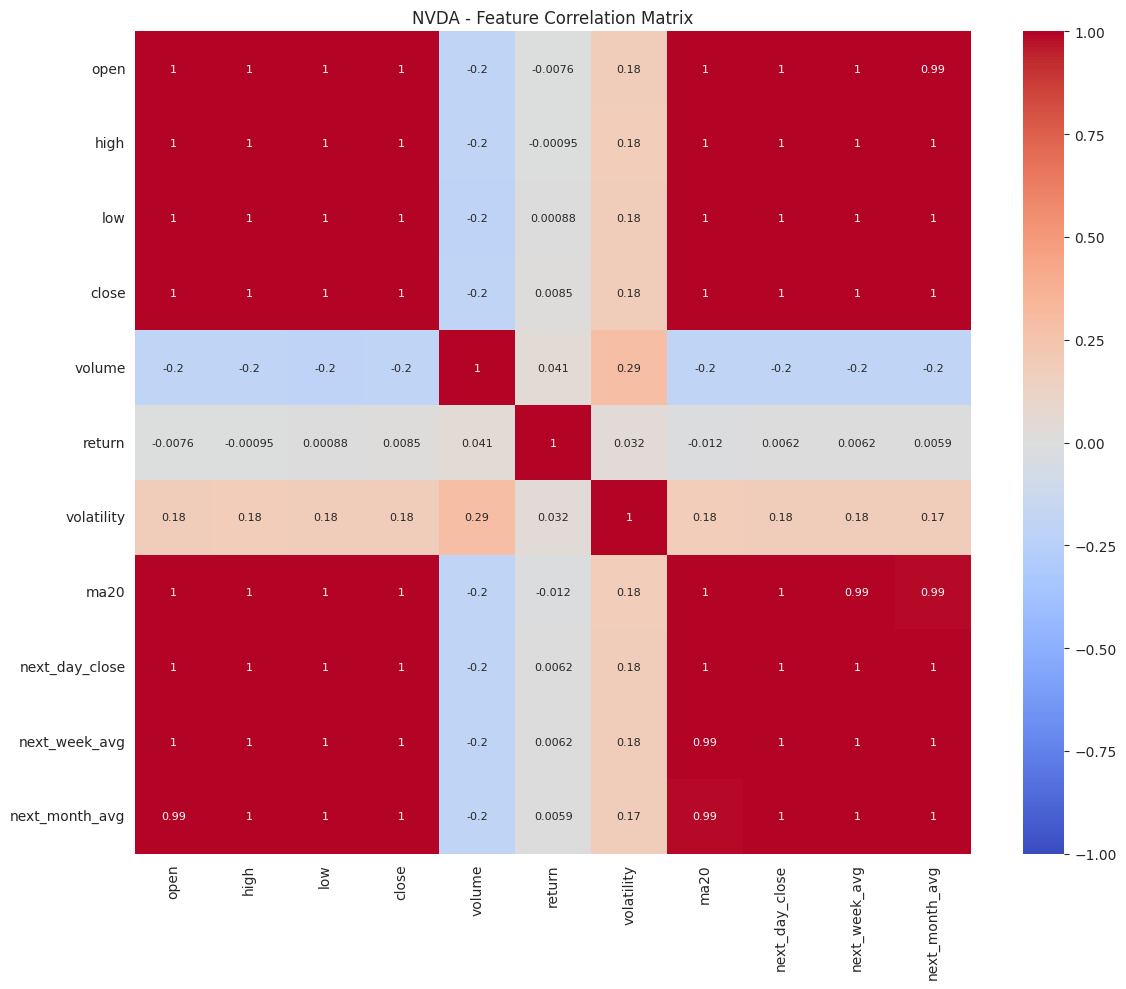


Visualizing AMZN...


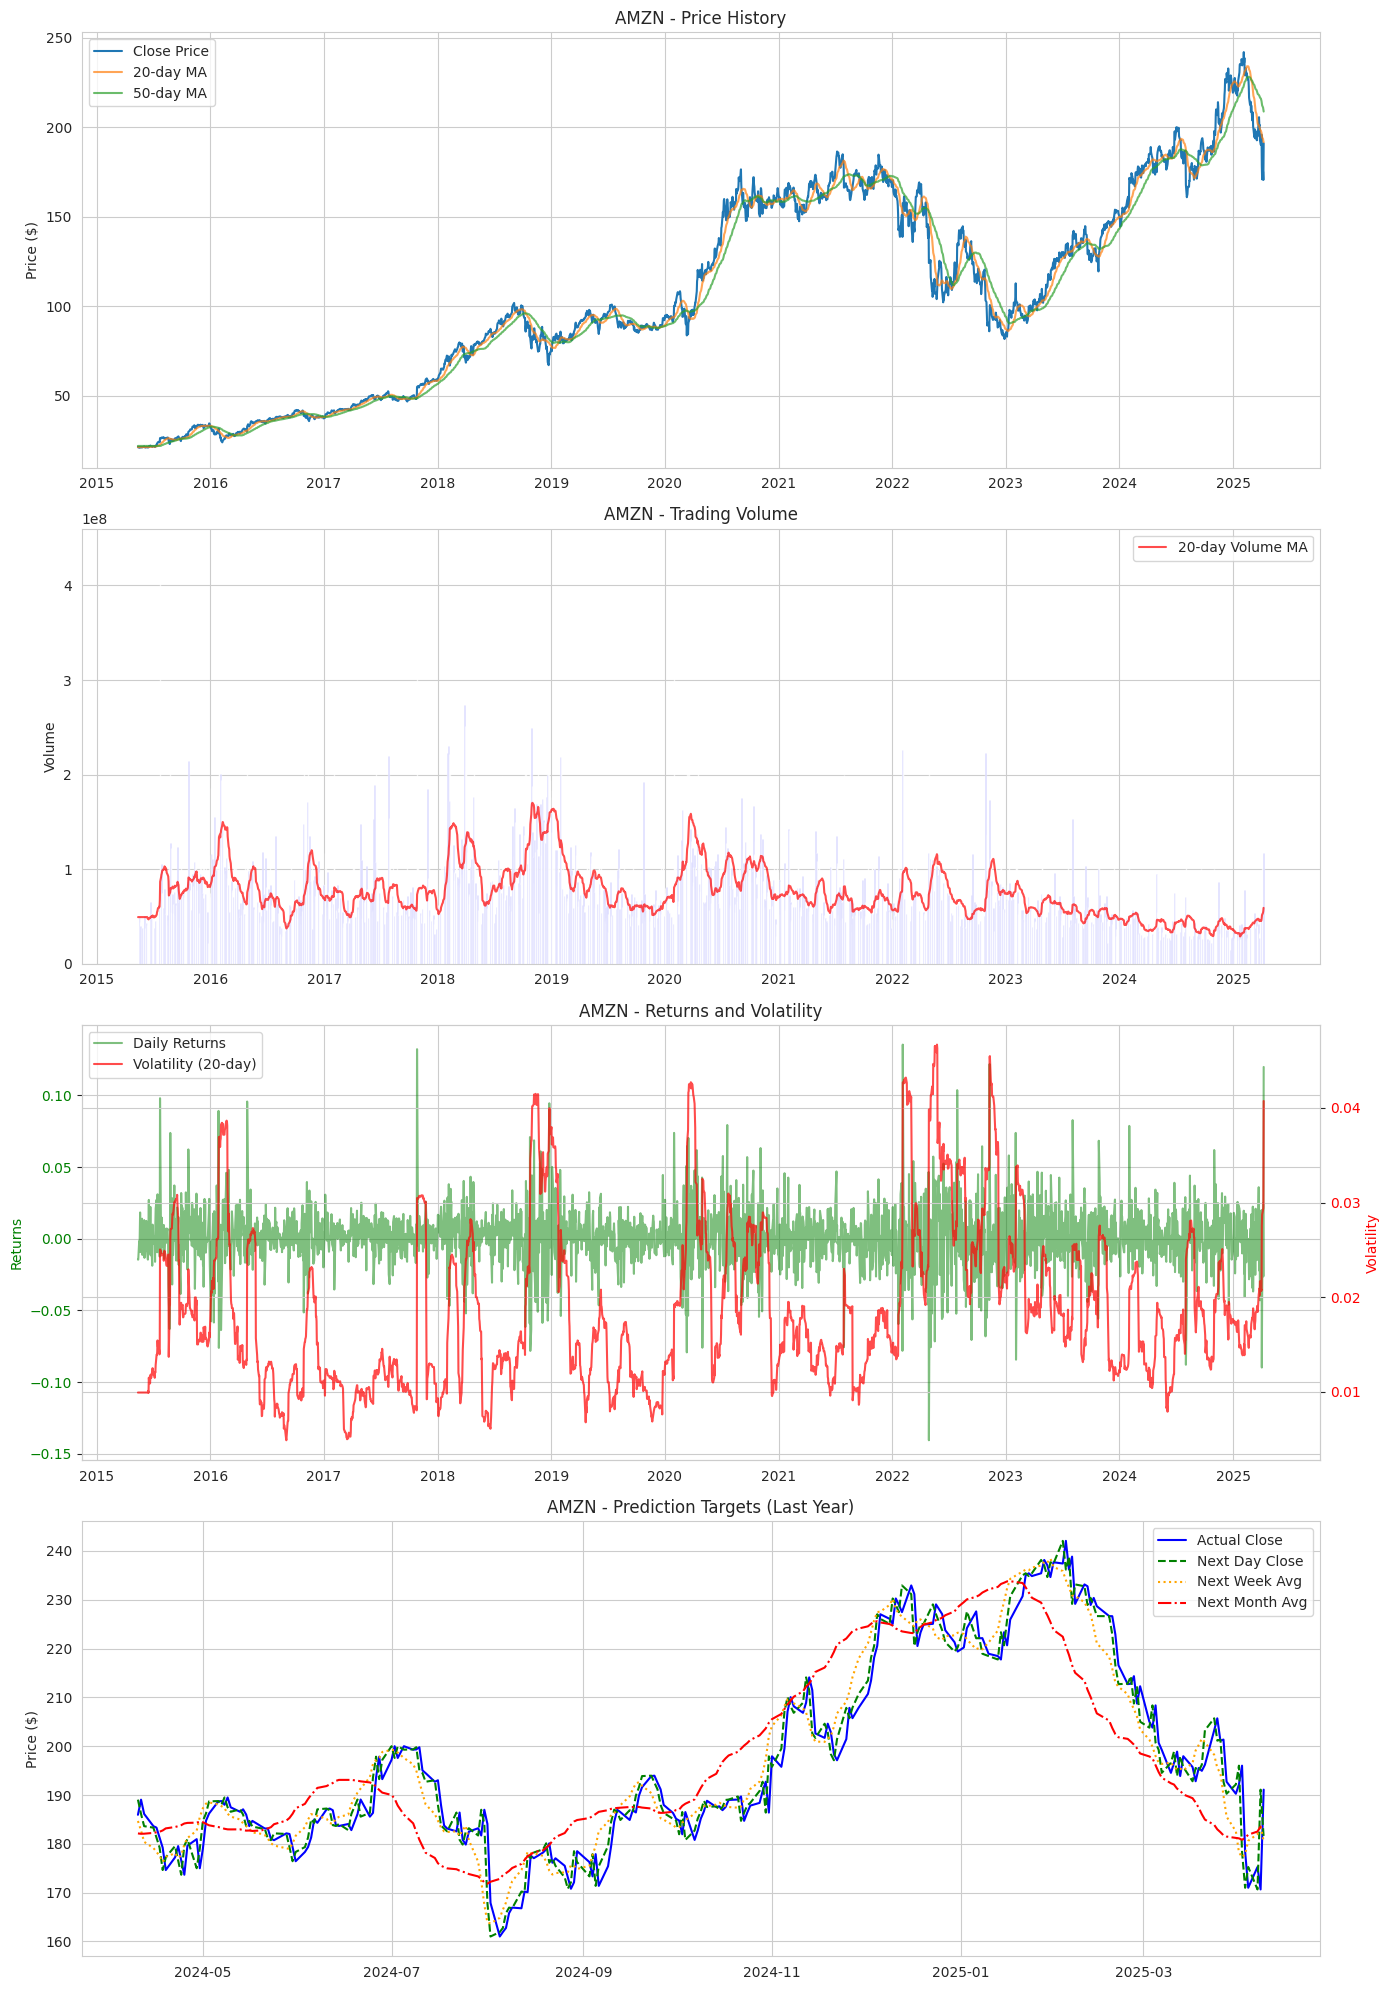

<Figure size 1200x1000 with 0 Axes>

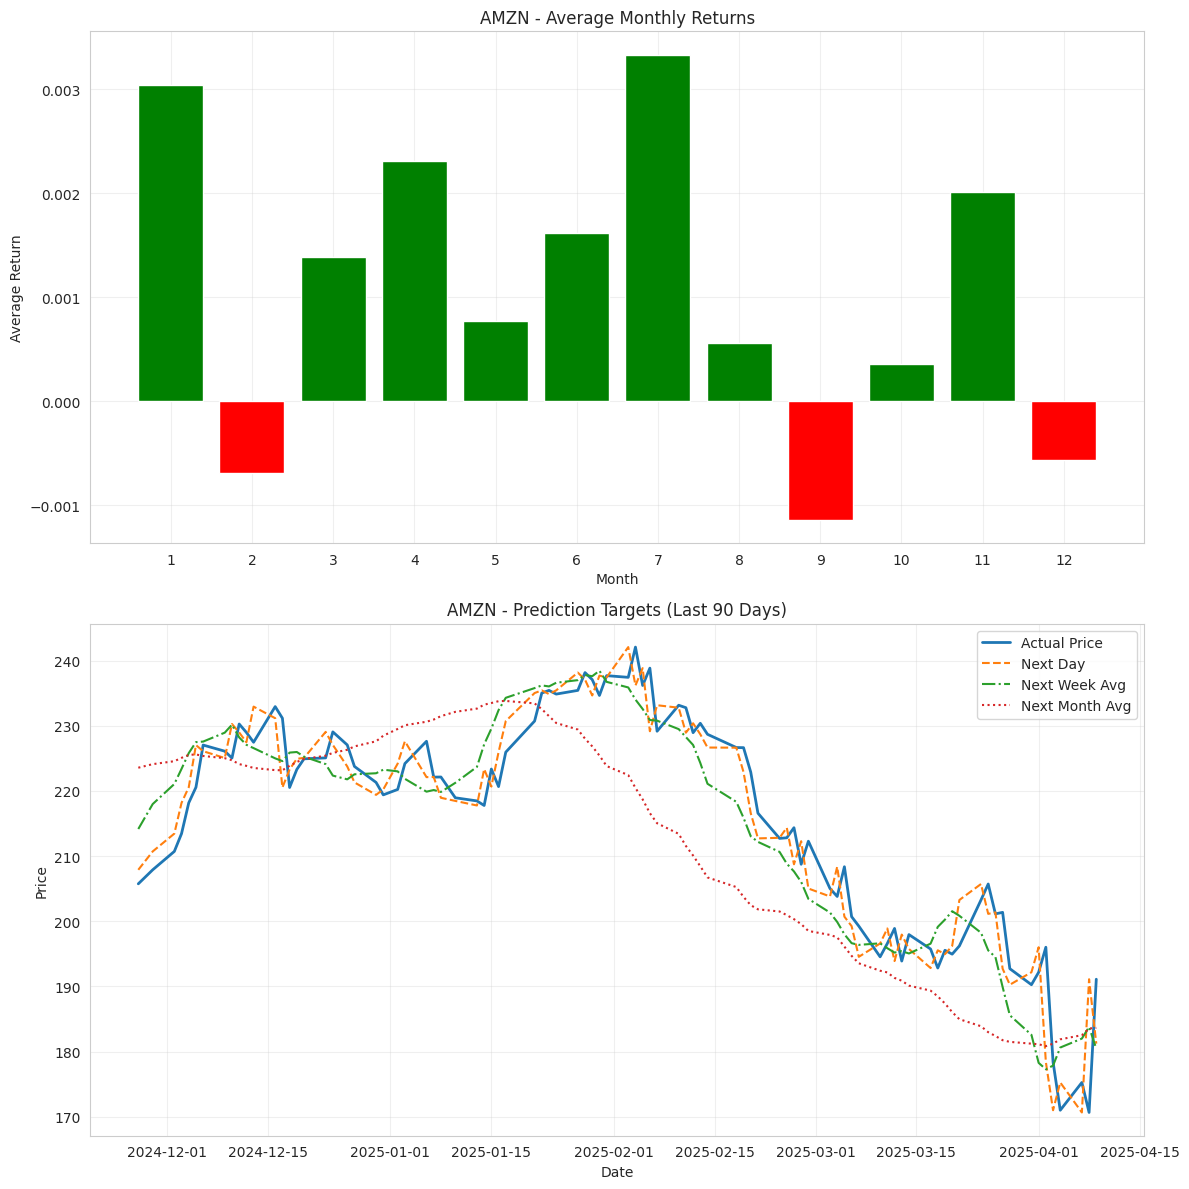


AMZN Statistics:
Data range: 2015-05-14 00:00:00-04:00 to 2025-04-09 00:00:00-04:00
Total trading days: 2492
Average daily return: 0.0011
Standard deviation of returns: 0.0207


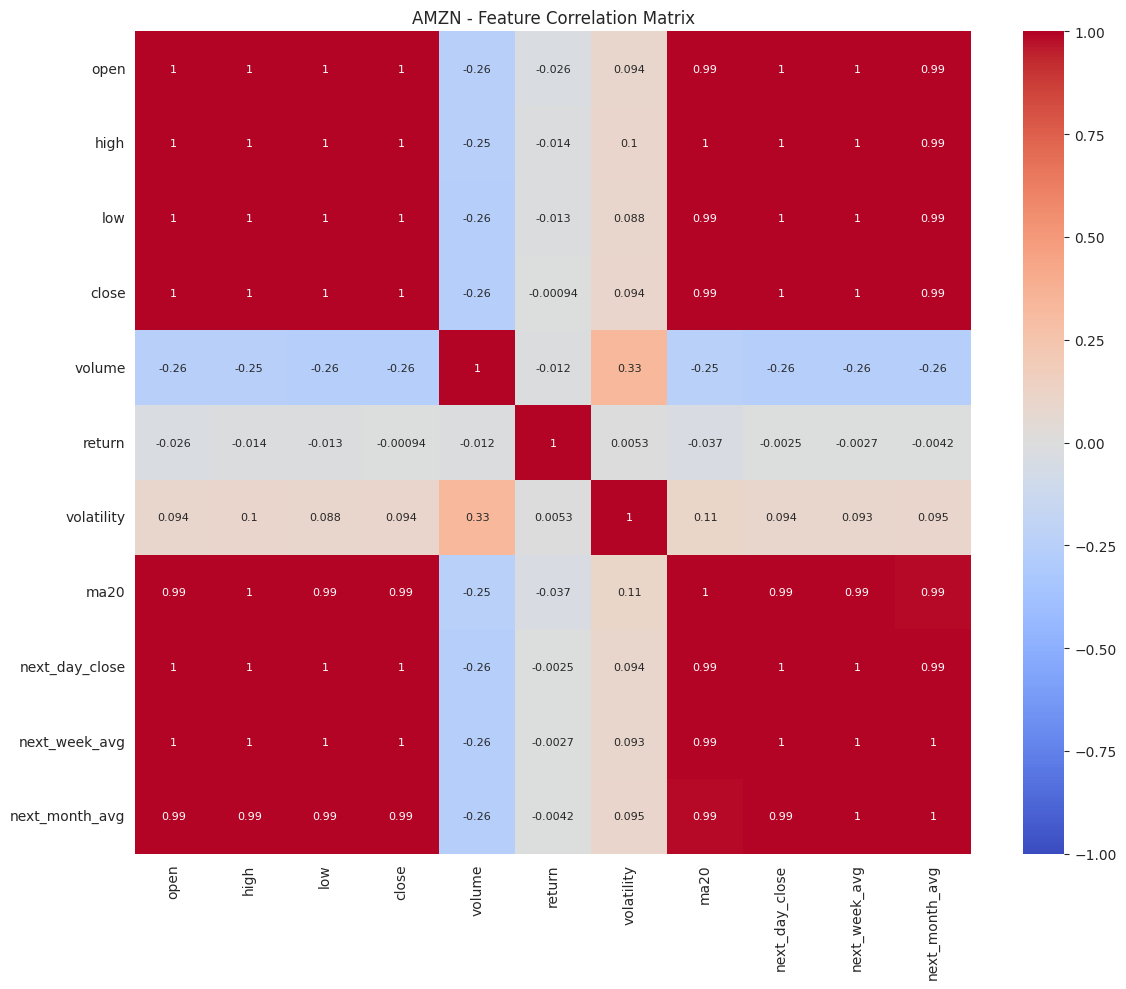

In [11]:
# Visualize a few selected stocks
sample_stocks = ['AAPL', 'MSFT', 'TSLA', 'NVDA', 'AMZN']

for ticker in sample_stocks:
    if ticker in results:
        print(f"\nVisualizing {ticker}...")
        visualize_stock_data(results[ticker], ticker)
        
        # Display some basic statistics
        print(f"\n{ticker} Statistics:")
        print(f"Data range: {results[ticker]['date'].min()} to {results[ticker]['date'].max()}")
        print(f"Total trading days: {len(results[ticker])}")
        print(f"Average daily return: {results[ticker]['return'].mean():.4f}")
        print(f"Standard deviation of returns: {results[ticker]['return'].std():.4f}")
        
        # Display correlation matrix for selected columns
        corr_cols = ['open', 'high', 'low', 'close', 'volume', 'return', 'volatility', 'ma20', 'next_day_close', 'next_week_avg', 'next_month_avg']
        corr_matrix = results[ticker][corr_cols].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, annot_kws={"size": 8})
        plt.title(f"{ticker} - Feature Correlation Matrix")
        plt.tight_layout()
        plt.show()

## 11. Conclusion and Next Steps

We have successfully:
1. Fetched 10 years of historical data for 20 stocks
2. Cleaned and processed the data
3. Added derived features (moving averages, volatility, etc.)
4. Created prediction targets for three time horizons: next day, next week, and next month
5. Visualized the data to understand patterns and verify correctness
6. Saved cleaned datasets to `data/cleaned/` for further processing

### Key Insights
- We've observed varying degrees of volatility and returns across different stocks
- Technology stocks generally show higher volatility but also higher returns
- The three prediction horizons (day, week, month) provide different perspectives on price movements

### Next Steps
The cleaned datasets are now ready to be used in model-specific preparation notebooks. We'll create separate models for each prediction horizon using the same underlying dataset to ensure optimal prediction accuracy:

1. Day prediction model: Trained to predict `next_day_close`
2. Week prediction model: Trained to predict `next_week_avg`
3. Month prediction model: Trained to predict `next_month_avg`

This approach will allow us to maintain one streamlined dataset while still achieving specialized accuracy for each prediction timeframe.